# General Settings and Imports

In [963]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [964]:
#general stuff
import pandas as pd
import numpy as np
import json
from pprint import pprint
import datetime
import os

#bfs
from collections import deque

#ofac stuff
import csv
import requests
#import json
import xmltodict
from collections import defaultdict

#dark web stuff
#import pyarrow.parquet as pq
#from pybloom_live import ScalableBloomFilter
import dask.dataframe as dd

#for graphsense tag data extraction
#from fastparquet import ParquetFile
#import snappy

#for flipside.xyz (SQL Databse)
#from flipside import Flipside

#graphsense stuff
import graphsense
from graphsense.api import addresses_api, bulk_api, entities_api, general_api, tags_api
from graphsense.model.neighbor_addresses import NeighborAddresses

#coinbase stuff
#import json, requests
import hmac, hashlib, time
from requests.auth import AuthBase

#visualization stuff
import matplotlib.pyplot as plt

In [965]:
f = open('config.json')
config = json.load(f)
f.close()

CURRENCY = 'eth'
ADDRESS = '0x974CaA59e49682CdA0AD2bbe82983419A2ECC400'

configuration = graphsense.Configuration(
    host = config['graphsense']['host'],
    api_key = {'api_key': config['graphsense']['api_key']})

#with graphsense.ApiClient(configuration) as api_client:
    #api_instance = general_api.GeneralApi(api_client)
    #api_response = api_instance.get_statistics()
    #pprint(api_response)

# Associated Wallets Module

In [966]:
class AssociatedWallets():
    
    def simple_neighbors(self, address, direction):
        with graphsense.ApiClient(configuration) as api_client:
            # Create an instance of the API class
            api_instance = addresses_api.AddressesApi(api_client)
            currency = CURRENCY # str | The cryptocurrency code (e.g., eth)
            address = ADDRESS # str | The cryptocurrency address
            direction = "out" # str | Incoming or outgoing neighbors
            only_ids = [
                "only_ids_example",
            ] # [str] | Restrict result to given set of comma separated addresses (optional)
            include_labels = False # bool | Whether to include labels of first page of address tags (optional) if omitted the server will use the default value of False
            page = "page_example" # str | Resumption token for retrieving the next page (optional)
            pagesize = 10 # int | Number of items returned in a single page (optional)

            # example passing only required values which don't have defaults set
            try:
                # Get an address's neighbors in the address graph
                api_response = api_instance.list_address_neighbors(currency, address, direction)
                return api_response
            except graphsense.ApiException as e:
                print("Exception when calling AddressesApi->list_address_neighbors: %s\n" % e)

            # example passing only required values which don't have defaults set
            # and optional values
            #try:
                # Get an address's neighbors in the address graph
                #api_response = api_instance.list_address_neighbors(currency, address, direction, only_ids=only_ids, include_labels=include_labels, page=page, pagesize=pagesize)
                #pprint(api_response)
            #except graphsense.ApiException as e:
                #print("Exception when calling AddressesApi->list_address_neighbors: %s\n" % e)

    #Utility function to get neighbors of address        
    def get_addr_neighbors(self, address, direction):

        if (direction == 'out'):
            degree = 'out_degree'
            address_degree = 'address_out_degree'
        else:
            degree = 'in_degree'
            address_degree = 'address_in_degree'

        with graphsense.ApiClient(configuration) as api_client:
            try:
                api_instance = bulk_api.BulkApi(api_client)
                print(f"get_addr_neighbors of {address}")
                operation = "list_address_neighbors"
                body = {'address': [address], 'direction': direction}

                df_address_neighbors = pd.read_csv(api_instance.bulk_csv(CURRENCY, operation, body=body,
                                                                    num_pages=1, _preload_content=False))
                
                df_address_neighbors = df_address_neighbors \
                    .loc[(df_address_neighbors['_error'] != 'not found') &
                        (df_address_neighbors['_info'] != 'no data')].reset_index(drop=True)
                
                if df_address_neighbors.empty:
                    df_address_neighbors.columns = ['address', 'entity', degree]
                    return df_address_neighbors
                
                print(df_address_neighbors.columns)  # Print column names

                
                df_address_neighbors = df_address_neighbors \
                    .rename(columns={'address_address': 'address', 
                                    'address_entity': 'entity',
                                    address_degree: degree})

                return df_address_neighbors[['address', 'entity', degree]]
                
            except graphsense.ApiException as e:
                print("Exception when calling Bulk Api: %s\n" % e)

    # The Breadth-First Search algorithm:
    def bfs_neighbors(self, seed_address, max_depth, max_degree, verbose, direction):

        if (direction == 'out'):
            degree = 'out_degree'
            #address_degree = 'address_out_degree'
        else:
            degree = 'in_degree'
            #address_degree = 'address_in_degree'
        
        # collect neighbors
        neighbors = []
        for i in range (0, max_depth):
            neighbors.insert(i, [])
        neighbors[0].append(seed_address)

        #keep track of depth
        levels = {seed_address: 0}
                
        # record visited addresses and entities
        visited_addresses = set([seed_address])
        
        # maintain a queue of addresses
        queue = deque([(seed_address, 0)])

        while(queue):

            # get first address from the queue
            addr, level = queue.popleft()            

            # retrieve address neighbors
            df_neighbors = self.get_addr_neighbors(addr, direction)

            # continue with neighbors out_degree < max_outdegree
            for index, neighbor in df_neighbors.iterrows():

                 # stop if address has already been visited
                if(neighbor['address'] in visited_addresses):
                    if verbose:
                        print(addr, end=' ') 
                        print("STOP | same address")
                    continue
                                
                # stop if max depth is reached
                if level + 1 == max_depth:
                    print(level)
                    if verbose:
                        print(addr, end=' ') 
                        print("STOP | max depth")
                    continue

                neighbors[level+1].append(neighbor['address'])

                # stop if address out_degree exceeds threshold
                if(neighbor[degree] > max_degree):
                    if verbose:
                        print(addr, end=' ') 
                        print("STOP | max degree")
                    continue
                
                queue.append((neighbor['address'], level + 1))
                visited_addresses.add(neighbor['address'])
                levels[neighbor['address']] = level + 1
                    
            if len(queue) == 0:
                return neighbors

# Blacklist Module

In [967]:
class Blacklist():
    
    def scrape_ofac(self):

        coins = []
        myCoins = {}
        sdn = defaultdict(list)
        filename = 'sdn2.xml'
        URL = "https://www.treasury.gov/ofac/downloads/sanctions/1.0/sdn_advanced.xml"

        response = requests.get(URL)
        with open(filename, 'wb') as file:
            file.write(response.content)

        xml_data = open(filename, 'r').read()  # Read file
        d = xmltodict.parse(xml_data)

        for i in d['Sanctions']['ReferenceValueSets']['FeatureTypeValues']['FeatureType']:
            if 'Digital Currency Address' in i['#text']:
                coins.append(i['@ID'])
                myCoins[i['@ID']] =  i['#text'].replace('Digital Currency Address - ','')
            #   print(i['@ID'],'-',i['#text'])

        for i in d['Sanctions']['DistinctParties']['DistinctParty']:
            if 'Feature' in i['Profile'].keys():
                for j in i['Profile']['Feature']:
                    if '@FeatureTypeID' in j:
                        if type(j) is not str:
                            if str(j['@FeatureTypeID']) in coins:
                            #   print(j)
                            #   print(j['FeatureVersion']['VersionDetail']['#text'])
                                sdn[myCoins[j['@FeatureTypeID']]].append(j['FeatureVersion']['VersionDetail']['#text'])            
                            #    break
            
        with open('results/sdn.json', 'w') as fp:
            json_data = json.dump(sdn, fp)
        fp.close()

    def check_membership_ofac(self, currency, address, json_data):

        currency_set = set(json_data[currency])
        return address in currency_set
    
    def check_dark_web(self, address, parent_directory):

        #pd.set_option('display.max_colwidth', None)
    
        def scan_directory(directory):

            #Recursively scans a directory for Parquet files and checks them.

            for item in os.listdir(directory):

                item_path = os.path.join(directory, item)
                
                # If item is a directory, recursively scan it
                if os.path.isdir(item_path):
                    if scan_directory(item_path):
                        return True

                # If item is a parquet file, read and check it
                elif item.endswith(".parquet"):
                    ddf = dd.read_parquet(item_path, blocksize="400mb")
                    print(ddf.head())

                    check = ddf['address'].isin([address]).compute()
                    if check.any():
                        return True
                    
            return False

        return scan_directory(parent_directory)


# Exchanges Module

In [968]:
class Exchange():
    
    def __init__(self, depth, direction):
        self.DEPTH = depth
        self.DIRECTION = direction

    def get_ex_tags(self, address, type):

        # Enter a context with an instance of the API client
        with graphsense.ApiClient(configuration) as api_client:
            # Create an instance of the API class
            api_instance = addresses_api.AddressesApi(api_client)

            currency = CURRENCY # str | The cryptocurrency code (e.g., btc)
            #address = ADDRESS # str | The cryptocurrency address
            page = "page_example" # str | Resumption token for retrieving the next page (optional)
            pagesize = 10 # int | Number of items returned in a single page (optional)
            include_tags = True

            # example passing only required values which don't have defaults set
            try:
                # Get attribution tags for a given address
                api_response = api_instance.list_tags_by_address(currency, address.lower())
                exchange_data = api_response
                
                exchange_tags = []

                for entry in exchange_data['address_tags']:
                    actor = entry.get('actor', '')
                    category = entry.get('category', '')
                    label = entry.get('label', '')
                    if ((actor or label) and (type == 'cex' and (category == 'exchange' or category == 'market'))) or ((actor or label) and type == 'dex' and category == 'defi_dex'):
                        exchange_tags.append({
                            'actor': actor,
                            'category': category,
                            'currency': entry.get('currency', ''),
                            'label': label,
                            'address': entry.get('address', '')
                        })

                return exchange_tags
                
            except graphsense.ApiException as e:
               print("Exception when calling AddressesApi->list_tags_by_address: %s\n" % e)
    
    def get_ex_used(self, type, max_degree=7, verbose=True):

        #hier einfach neighbors von ADDRESS finden mit der self.depth dann jedes von denen in get_cex_tags und dann falls result nicht empty ist einf in einer liste alles speichern und dann printen
        
        ass_wallets = AssociatedWallets()
        neighbors = ass_wallets.bfs_neighbors(ADDRESS, self.DEPTH, max_degree, verbose, self.DIRECTION)

        exchanges_used = []

        for arr_level in neighbors:
            for address in arr_level:
                temp_exchange_tags = self.get_ex_tags(address, type)
                if temp_exchange_tags:
                    exchanges_used.append(temp_exchange_tags)

        return exchanges_used

# Proof of Funds Module

In [969]:
# Create custom authentication for Coinbase API
class CoinbaseWalletAuth(AuthBase):
    def __init__(self, api_key, secret_key):
        self.api_key = api_key
        self.secret_key = secret_key

    def __call__(self, request):
        timestamp = str(int(time.time()))
        message = timestamp + request.method + request.path_url + (request.body or '')
        signature = hmac.new(self.secret_key, message, hashlib.sha256).hexdigest()

        request.headers.update({
            'CB-ACCESS-SIGN': signature,
            'CB-ACCESS-TIMESTAMP': timestamp,
            'CB-ACCESS-KEY': self.api_key,
        })
        return request

class PoF():

    #Candles data Coinbase

    """Each bucket is an array of the following information:

    time: bucket start time
    low: lowest price during the bucket interval
    high: highest price during the bucket interval
    open: opening price (first trade) in the bucket interval
    close: closing price (last trade) in the bucket interval
    volume: volume of trading activity during the bucket interval"""
    
    def coinbase_data(self, type, start_date=datetime.date.today()):

        # Before implementation, set environmental variables with the names API_KEY and API_SECRET

        #API_KEY = config['coinbase']['api_key']
        #API_SECRET = config['coinbase']['api_secret']
        #auth = CoinbaseWalletAuth(API_KEY, API_SECRET)

        if type == 'buy':
            api_url = config['coinbase']['buyprice_endpoint']
        elif type == 'sell':
            api_url = config['coinbase']['sellprice_endpoint']
        elif type == 'exchange':
            api_url = config['coinbase']['exchangeprice_endpoint']
        elif type == 'spot':
            api_url = config['coinbase']['spotprice_endpoint']
        elif type == 'candles':
            api_url = config['coinbase']['candles_endpoint']

        # Convert the start date string to a datetime object
        #start_date_datetime = datetime.datetime.strptime(start_date, "%Y-%m-%d")

        # Calculate the end date by adding one day to the start date
        #end_date_datetime = start_date_datetime + datetime.timedelta(days=1)

        # Convert the end date to a string in the same format
        #end_date = end_date_datetime.strftime("%Y-%m-%d")

        # Parameters for the API request
        params_spot = {
            "date": start_date
        }

        # Parameters for the API request
        params_candles = {
            "granularity": 86400,  # Daily interval
            "start": start_date,
            "end": start_date
        }

        # Get current user
        #r = requests.get(api_url + 'user', auth=auth)
        #print(r.json())
        # {u'data': {u'username': None, u'resource': u'user', u'name': u'User'...

        # Send funds
        """tx = {
            'type': 'send',
            'to': 'user@example.com',
            'amount': '10.0',
            'currency': 'USD',
        }"""

        #r = requests.post(api_url + 'accounts/primary/transactions', json=tx, auth=auth)
        #print(r.json())
        # {u'data': {u'status': u'pending', u'amount': {u'currency': u'BTC'...

        if (len(start_date) == 0):
            response = requests.get(api_url)
        else:
            if type == 'spot':
                response = requests.get(api_url, params=params_spot)
            elif type == 'candles':
                response = requests.get(api_url, params=params_candles)

        # Process the response data
        if response.status_code == 200:
            return response.json()
        else:
            print("Request failed:", response.status_code)

    
    #Klines data Binance
    """[
        [
            1499040000000,      // Kline open time
            "0.01634790",       // Open price
            "0.80000000",       // High price
            "0.01575800",       // Low price
            "0.01577100",       // Close price
            "148976.11427815",  // Volume
            1499644799999,      // Kline Close time
            "2434.19055334",    // Quote asset volume
            308,                // Number of trades
            "1756.87402397",    // Taker buy base asset volume
            "28.46694368",      // Taker buy quote asset volume
            "0"                 // Unused field, ignore.
        ]
        ]"""
    
    def binance_data(self, type, symbol='', start_date=datetime.date.today().strftime('%Y-%m-%d'), end_date=datetime.datetime.today().strftime('%Y-%m-%d')):

        if type == 'avgprice':
            api_url = config['binance']['avgprice_endpoint']
        elif type == 'price':
            api_url = config['binance']['price_endpoint']
        elif type == 'exchange':
            api_url = config['binance']['exchangeprice_endpoint']
        elif type == 'klines':
            api_url = config['binance']['klines_endpoint']
        elif type == '24hrstats':
            api_url = config['binance']['24hrstats_endpoint']
        
        # Convert start and end dates to Unix timestamps (in milliseconds)

        start_timestamp = int(datetime.datetime.strptime(start_date, "%Y-%m-%d").timestamp()) * 1000
        #end_timestamp = int(datetime.datetime.strptime(end_date, "%Y-%m-%d").timestamp()) * 1000

        # Parameters for the API request Klines
        params_klines = {
            "symbol": symbol,
            "interval": "1d",  # Daily interval
            "startTime": start_timestamp
            #"endTime": end_timestamp
        }

        # Parameters for the API request
        params_general = {
            "symbol": symbol,
            #"interval": "1d",  # Daily interval
            #"startTime": start_timestamp
            #"endTime": end_timestamp
        }

        if type == 'klines':
            response = requests.get(api_url, params=params_klines)
        elif type == 'exchange' and symbol == '':
            response = requests.get(api_url)
        else:
            response = requests.get(api_url, params=params_general)

        # Process the response data
        if response.status_code == 200:
            return response.json()
        else:
            print("Request failed:", response.status_code)
        
        
    def binance_table(self, ticker, interval='4h', limit=500, start='01-01-2023'):

        """
        interval: str tick interval - 4h/1h/1d ...
        """

        columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol','taker_quote_vol', 'ignore']
        start = int(datetime.datetime.timestamp(pd.to_datetime(start))*1000)
        api_url = f'https://www.binance.com/api/v3/klines?symbol={ticker}&interval={interval}&limit={limit}&startTime={start}'

        data = pd.DataFrame(requests.get(api_url).json(), columns=columns, dtype=float)

        data.index = [pd.to_datetime(x, unit='ms').strftime('%Y-%m-%d %H:%M:%S') for x in data.open_time]

        usecols=['open', 'high', 'low', 'close', 'volume', 'qav','num_trades','taker_base_vol','taker_quote_vol']
        
        data = data[usecols]

        return data
    
    
    def check_profitloss(self, exchange, symbol, buy_date, sell_date, buy_amount, sell_amount, profit_or_loss):
        
        if exchange == 'coinbase':
            
            buy_price_data = self.coinbase_data('candles', buy_date)
            sell_price_data = self.coinbase_data('candles', sell_date)

            buy_price = float(buy_price_data[0][3])
            sell_price = float(sell_price_data[0][3])

            buy_total = buy_price * buy_amount
            sell_total = sell_price * sell_amount
            
        elif exchange == 'binance':
            
            buy_price_data = self.binance_data('klines', buy_date, symbol)
            sell_price_data = self.binance_data('klines', sell_date, symbol)

            buy_price = float(buy_price_data[0][1])
            sell_price = float(sell_price_data[0][1])

            buy_total = buy_price * buy_amount
            sell_total = sell_price * sell_amount

        else:
            print(f"Unsupported exchange: {exchange}")
            return False

        difference = abs((buy_total - sell_total) - abs(profit_or_loss))
        actual_profit_or_loss = sell_total - buy_total
        
        if difference < 1e-6: #To account for floating point inaccuracies
            print("Actual profit/loss: " + str(actual_profit_or_loss))
            print("Difference between reported profit/loss and actual profit/loss value: " + str(difference))
            return True
        else:
            print("Actual profit/loss: " + str(actual_profit_or_loss))
            print("Difference between reported profit/loss and actual profit/loss value: " + str(difference))            
            return False
        

    def get_address_txs(self, address, currency, direction):

        # Enter a context with an instance of the API client
        with graphsense.ApiClient(configuration) as api_client:
            # Create an instance of the API class
            api_instance = addresses_api.AddressesApi(api_client)
            #currency = CURRENCY # str | The cryptocurrency code (e.g., btc)
            #address = ADDRESS # str | The cryptocurrency address
            #direction = "out" # str | Incoming or outgoing transactions (optional)
            #min_height = Height(1) # Height | Return transactions starting from given height (optional)
            #max_height = Height(2) # Height | Return transactions up to (including) given height (optional)
            #token_currency = "WETH" # str | Return transactions of given token currency (optional)
            #page = "page_example" # str | Resumption token for retrieving the next page (optional)
            #pagesize = 10 # int | Number of items returned in a single page (optional)

            # example passing only required values which don't have defaults set
            try:
                # Get all transactions an address has been involved in
                api_response = api_instance.list_address_txs(currency, address, direction=direction)
                return api_response
            except graphsense.ApiException as e:
                print("Exception when calling AddressesApi->list_address_txs: %s\n" % e)

            # example passing only required values which don't have defaults set
            # and optional values
            #try:
                # Get all transactions an address has been involved in
                #api_response = api_instance.list_address_txs(currency, address, direction=direction, min_height=min_height, max_height=max_height, token_currency=token_currency, page=page, pagesize=pagesize)
                #pprint(api_response)
            #except graphsense.ApiException as e:
                #print("Exception when calling AddressesApi->list_address_txs: %s\n" % e)


    def check_pass_through_wallet(self, address, currency):
          
        out_txs = self.get_address_txs(address.lower(), currency, 'out')
        in_txs = self.get_address_txs(address.lower(), currency, 'in')

        params = {
            "module": "account",
            "action": "balance",
            "address": address,
            "tag": "latest",
            "apikey": config['etherscan']['api_key']
        }
        
        response = requests.get(config['etherscan']['host'], params=params)
        data = response.json()

        if data['status'] != "1" or 'result' not in data:
            print(f"Error fetching transactions for address {address}: {data['message']}")
            return []
        
        balance_eth = float(data['result']) / (10 ** 18)  # Convert wei to ether

        print("Number of incoming txs: " + str(len(in_txs['address_txs'])))
        print("Number of outgoing txs: " + str(len(out_txs['address_txs'])))
        print(balance_eth)

# NFTs Module

In [970]:
class NFT():

    def get_nft_transfers(self, address, page=1, offset=100):

        params = {
            "module": "account",
            "action": "tokennfttx",
            #"contractaddress": "",
            "address": address,
            "page": page,
            "offset": offset,
            #"startblock": "",
            #"endblock": "",
            "sort": "asc",
            "apikey": config['etherscan']['api_key']
         }
        
        response = requests.get(config['etherscan']['host'], params=params)
        data = response.json()

        if data['status'] != "1" or 'result' not in data:
            print(f"Error fetching transactions for address {address}: {data['message']}")
            return []

        return data['result']
    
    
    def get_held_nfts(self, address):
        
        transfers = self.get_nft_transfers(address)

        incoming_nfts = {tx['tokenID']: tx for tx in transfers if tx['to'] == address.lower()}
        outgoing_nfts = {tx['tokenID']: tx for tx in transfers if tx['from'] == address.lower()}

        held_nfts = {tid: tx for tid, tx in incoming_nfts.items() if tid not in outgoing_nfts}

        return list(held_nfts.values())


# ERC20 Module

In [971]:
class ERC20():
    

    def __init__(self, address):
        self.address = address


    def get_erc20_transfers(self, page=1, offset=100):

        params = {
            "module": "account",
            "action": "tokentx",
            #"contractaddress": "",
            "address": self.address,
            "page": page,
            "offset": offset,
            #"startblock": "",
            #"endblock": "",
            "sort": "asc",
            "apikey": config['etherscan']['api_key']
         }
        
        response = requests.get(config['etherscan']['host'], params=params)
        data = response.json()

        if data['status'] != "1" or 'result' not in data:
            print(f"Error fetching transactions for address {self.address}: {data['message']}")
            return []

        return data['result']
    
    
    def get_erc20(self):
        
        transfers = self.get_erc20_transfers(self.address)

        erc20_balances = {}
        
        # Sum up all the incoming and outgoing transfers for each token
        for tx in transfers:

            token_key = (tx['tokenSymbol'], tx['tokenName'])
            value = float(tx['value']) / (10.0 ** float(tx['tokenDecimal']))
            
            if tx['to'] == self.address.lower():
                erc20_balances[token_key] = erc20_balances.get(token_key, 0) + value
            if tx['from'] == self.address.lower():
                erc20_balances[token_key] = erc20_balances.get(token_key, 0) - value

        # Filter out tokens with zero or negative balances
        held_erc20 = {k: v for k, v in erc20_balances.items() if v > 0}

        return held_erc20

    
    def visualize(self):
        #create a pie chart of held erc20 tokens

        held_erc20 = self.get_erc20()
        pof = PoF()
        pie_data = []
        pie_labels = []

        if held_erc20:

            for token, value in held_erc20.items():

                symbol = token[0]

                if symbol != 'USDT':
                    trading_pair = symbol + 'USDT'
                    binance_call = pof.binance_data('price', trading_pair)
                    if binance_call:
                        symbol_price = float(binance_call['price'])
                else: 
                    symbol_price = 1.0

                pie_data.append(symbol_price * value)
                pie_labels.append(symbol)
                
        else:
            print(f"Error fetching transactions for address {self.address}")

        # Plot

        plt.pie(pie_data)
        plt.legend(pie_labels, title="Tokens", loc="best")
        plt.title('ERC20 Tokens in USDT')
        plt.figure(figsize=(50, 40)) # 10 width, 8 height
        plt.show()
        print(held_erc20)


# Smart Contract Module

In [972]:
class SC():

    def get_sc_data(self, contract_address, type):

        params_sc = {
            "module": "contract",
            "action": "getsourcecode",
            "address": contract_address,
            "apikey": config['etherscan']['api_key']
        }
        response_sc = requests.get(config['etherscan']['host'], params=params_sc)
        data_sc = response_sc.json()

        params_creator = {
            "module": "contract",
            "action": "getcontractcreation",
            "address": contract_address,
            "apikey": config['etherscan']['api_key']
        }
        response_creator = requests.get(config['etherscan']['host'], params=params_creator)
        data_creator = response_creator.json()

        if data_sc["status"] == "1":
            source_code = data_sc["result"][0]["SourceCode"]
            with open("results/sc_" + str(type) + "_" + data_sc["result"][0]["ContractName"] + ".txt", "w") as outfile:
                outfile.write(str(source_code))
        else:
            print(f"Error Smart Contract: {data_sc['message']}")

        if data_creator["status"] == "1":
            creator_data = data_creator["result"]
            with open("results/creator_" + str(type) + ".txt", "w") as outfile:
                outfile.write(str(creator_data))
        else:
            print(f"Error Creator: {data_creator['message']}")

# Main Section

Request failed: 400
Request failed: 400
Request failed: 400


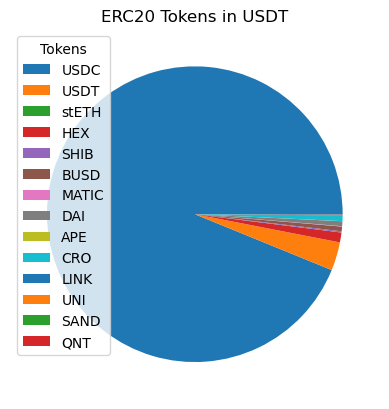

<Figure size 5000x4000 with 0 Axes>

{('USDC', 'USD Coin'): 672591.830022, ('USDT', 'Tether USD'): 22282.145143993694, ('stETH', 'stETH'): 5e-18, ('HEX', 'HEX'): 7709.26473665, ('SHIB', 'SHIBA INU'): 138370577.44590515, ('BUSD', 'BUSD'): 3640.5814408036517, ('MATIC', 'Matic Token'): 570.0014473363542, ('DAI', 'Dai Stablecoin'): 3768.9079341, ('APE', 'ApeCoin'): 72.03080473000001, ('CRO', 'Cronos Coin'): 3594.99824913, ('LINK', 'ChainLink Token'): 118.94699802817439, ('UNI', 'Uniswap'): 29.47157980073113, ('SAND', 'SAND'): 16.32589337, ('QNT', 'Quant'): 1.10521158}


In [973]:
# Function calls

#ass_wallets = AssociatedWallets(CURRENCY)

#direction = 'out'

#addr_neigh = ass_wallets.bfs_neighbors(ADDRESS, 4, 10, True, direction)
#addr_simple_neigh = ass_wallets.simple_neighbors(ADDRESS, direction)

#with open("results/addresses_" + direction + ".txt", "w") as outfile:
    #outfile.write(str(addr_neigh))

#blacklist = Blacklist()
#blacklist.ofac()
#print(blacklist.check_membership('ETH', ADDRESS, json_data))
#blacklist.check_dark_web('1DcU28QbeUiJVcSS8sZCf4ixeYXG26zEWN', 'blacklist_data/address_cluster.parquet')

 # Open the JSON file
#with open('results/sdn.json', 'r') as file:
    # Load the JSON data
    #json_data = json.load(file)


#ex = Exchange(3, 'in')
#exchanges_used = ex.get_ex_used('dex')
#exchanges_used = ex.get_ex_tags('0x1d42064Fc4Beb5F8aAF85F4617AE8b3b5B8Bd801', 'dex')
#pprint(exchanges_used)

#pof = PoF()
#print(pof.coinbase_data('candles', '2018-01-01'))
#print(pof.binance_data('price', 'DOGEUSDT'))

#pprint(pof.binance_table('ETHUSDT', '1h'))
#pof.check_profitloss('coinbase', 'ETHUSDT', '2018-08-09', '2023-09-10', 1, 1, -300)
#pof.get_address_txs(ADDRESS.lower(), CURRENCY, 'out')
#pof.check_pass_through_wallet(ADDRESS, CURRENCY)

#nft = NFT()
#nfts_dict = nft.get_held_nfts(ADDRESS)
#print(nfts_dict)
#for nft in nfts_dict:
    #print(nft)

#nft_sc = nft.get_nft_sc('0x25ed58c027921e14d86380ea2646e3a1b5c55a8b')
#with open("results/nft_sc" + ".txt", "w") as outfile:
    #outfile.write(str(nft_sc))

erc20 = ERC20(ADDRESS)
#erc20_dict = erc20.get_erc20_transfers()
#print(erc20_dict)
#print(erc20.get_erc20())
erc20.visualize()

#sc = SC()
#sc.get_sc_data(exchanges_used[0]['address'], 'dex')